# Urban effects on FPS-SESA simulations


Let's first have a look at the urban fraction as seen by the model. This is land use type 13 (Urban and built-up) in MODIS data.

In [1]:
import xarray as xr

MODIS_LAND_USE = {
  'Urban and built-up': 13,
  'Water bodies': 17
}

url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/fx/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_fx_v20220727'
ds = xr.open_dataset(url)

This loaded all fixed variables information into `ds`. Variables can be accessed as attributes of this object. E.g. land use:

In [2]:
ds.landuse

<xarray.DataArray 'landuse' (lat: 451, lon: 676)>
[304876 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat      (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
Attributes:
    standard_name:  land_cover
    long_name:      Land Cover
    units:          1
    cell_methods:   time: point
    _ChunkSizes:    [50 50]

This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

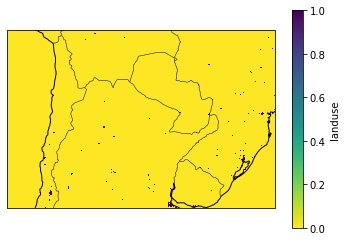

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfea
from matplotlib import cm

p = (ds.landuse == MODIS_LAND_USE['Urban and built-up']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.viridis_r
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

Major rivers and lakes are also seen by the model at this resolution.

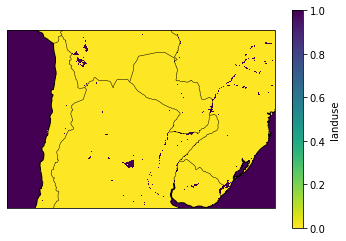

In [4]:
p = (ds.landuse == MODIS_LAND_USE['Water bodies']).plot(
    transform = ccrs.PlateCarree(),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.viridis_r
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## to be continued ...